In [1]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler


e:\00-Personal\code\challenge_dae_meli\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Carga de datos

In [2]:
df_original = pd.read_csv('../data/01_raw/df_challenge_meli.csv', encoding='latin-1')
df_sellers_clustered = pd.read_csv('../data/02_processed/df_sellers_clustered.csv', encoding='latin-1')

In [3]:
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185250 entries, 0 to 185249
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   tim_day            185250 non-null  object 
 1   seller_nickname    185250 non-null  object 
 2   titulo             185250 non-null  object 
 3   seller_reputation  182878 non-null  object 
 4   stock              185250 non-null  int64  
 5   logistic_type      185250 non-null  object 
 6   condition          185250 non-null  object 
 7   is_refurbished     185250 non-null  bool   
 8   price              183734 non-null  float64
 9   regular_price      49956 non-null   float64
 10  categoria          185250 non-null  object 
 11  url                185250 non-null  object 
 12  category_id        185250 non-null  object 
 13  category_name      185250 non-null  object 
dtypes: bool(1), float64(2), int64(1), object(10)
memory usage: 18.6+ MB


## Agrupar titulos de productos

In [4]:
seller_text_profiles = df_original.groupby('seller_nickname')['titulo'].apply(lambda x: ' '.join(x)).reset_index()
seller_text_profiles.rename(columns={'titulo': 'catalogo_texto'}, inplace=True)

df_final = pd.merge(seller_text_profiles, df_sellers_clustered, on='seller_nickname')

In [5]:
min_members = 2

cluster_counts = df_final['cluster'].value_counts()
clusters_to_keep = cluster_counts[cluster_counts >= min_members].index
df_filtered = df_final[df_final['cluster'].isin(clusters_to_keep)]

print(f"Número de vendedores antes del filtrado: {len(df_final)}")
print(f"Número de vendedores después del filtrado: {len(df_filtered)}")
print(f"Clústeres con menos de {min_members} miembros han sido removidos para el entrenamiento.\n")

Número de vendedores antes del filtrado: 46586
Número de vendedores después del filtrado: 46585
Clústeres con menos de 2 miembros han sido removidos para el entrenamiento.



## Modelo de embeddings

In [6]:
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(df_filtered['catalogo_texto'].tolist(), show_progress_bar=True)

print(f"Embeddings generados. Forma de la matriz de embeddings: {embeddings.shape}")
print("Cada vendedor ahora está representado por un vector de 384 dimensiones.\n")


Batches: 100%|██████████| 1456/1456 [07:41<00:00,  3.15it/s]


Embeddings generados. Forma de la matriz de embeddings: (46585, 384)
Cada vendedor ahora está representado por un vector de 384 dimensiones.



In [7]:
X = embeddings
y = df_filtered['cluster']

In [8]:
print(f"Distribución de clases: {Counter(y)}")

Distribución de clases: Counter({0: 31894, 2: 8650, 1: 4931, 6: 808, 4: 267, 5: 35})


Clases desbalanceadas. Se requiere balancear etiquetas

In [9]:
smote = SMOTE(random_state=32)
X_resampled, y_resampled = smote.fit_resample(X, y)
print(f"Distribución de clases DESPUES del balanceo: {Counter(y_resampled)}")

Distribución de clases DESPUES del balanceo: Counter({0: 31894, 2: 31894, 1: 31894, 6: 31894, 4: 31894, 5: 31894})


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=32, stratify=y_resampled)
print(f"Datos divididos: {len(X_train)} para entrenamiento, {len(X_test)} para prueba.\n")

Datos divididos: 153091 para entrenamiento, 38273 para prueba.



In [11]:
classifier = LogisticRegression(random_state=32, max_iter=1000)
classifier.fit(X_resampled, y_resampled)
print("Modelo de clasificación entrenado exitosamente.\n")

Modelo de clasificación entrenado exitosamente.



## Evaluación

In [12]:
y_pred = classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Exactitud (Accuracy) del modelo: {accuracy:.2%}")
print("Esta métrica indica el porcentaje de vendedores que el modelo clasificó correctamente.\n")

print("Informe de Clasificación Detallado:")
print(classification_report(y_test, y_pred))

Exactitud (Accuracy) del modelo: 81.54%
Esta métrica indica el porcentaje de vendedores que el modelo clasificó correctamente.

Informe de Clasificación Detallado:
              precision    recall  f1-score   support

           0       0.64      0.56      0.60      6379
           1       0.76      0.75      0.75      6379
           2       0.75      0.72      0.74      6379
           4       0.81      0.88      0.84      6379
           5       0.98      1.00      0.99      6379
           6       0.93      0.97      0.95      6378

    accuracy                           0.82     38273
   macro avg       0.81      0.82      0.81     38273
weighted avg       0.81      0.82      0.81     38273



In [14]:
y_pred = classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Exactitud (Accuracy) del modelo: {accuracy:.2%}")
print("Esta métrica indica el porcentaje de vendedores que el modelo clasificó correctamente.\n")

print("Informe de Clasificación Detallado:")
print(classification_report(y_test, y_pred))

Exactitud (Accuracy) del modelo: 81.54%
Esta métrica indica el porcentaje de vendedores que el modelo clasificó correctamente.

Informe de Clasificación Detallado:
              precision    recall  f1-score   support

           0       0.64      0.56      0.60      6379
           1       0.76      0.75      0.75      6379
           2       0.75      0.72      0.74      6379
           4       0.81      0.88      0.84      6379
           5       0.98      1.00      0.99      6379
           6       0.93      0.97      0.95      6378

    accuracy                           0.82     38273
   macro avg       0.81      0.82      0.81     38273
weighted avg       0.81      0.82      0.81     38273



Matriz de confusión


Text(0.5, 58.7222222222222, 'Clúster Predicho')

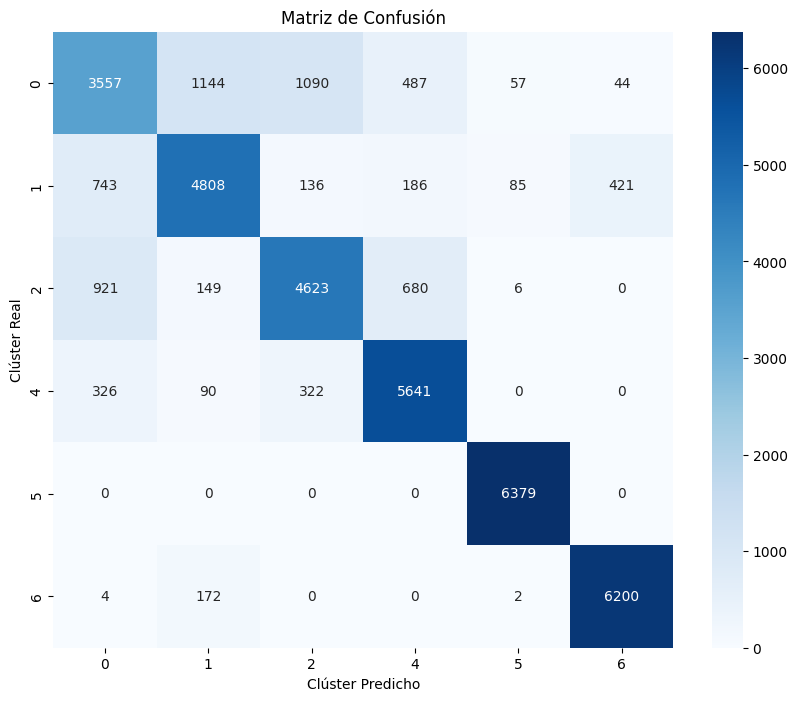

In [15]:
print("Matriz de confusión")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('Matriz de Confusión')
plt.ylabel('Clúster Real')
plt.xlabel('Clúster Predicho')
# plt.savefig('confusion_matrix.png')
# print("Matriz de confusión guardada como 'confusion_matrix.png'\n")

## Uso práctico

In [ ]:
nuevo_vendedor_titulos = "Smartphone Samsung Galaxy S24 Ultra - Audifonos Bose Quietcomfort"
print(f"Títulos del nuevo vendedor: '{nuevo_vendedor_titulos}'")

nuevo_embedding = model.encode([nuevo_vendedor_titulos])

prediccion_cluster = classifier.predict(nuevo_embedding)
print(f"El modelo predice que este nuevo vendedor pertenece al Clúster: {prediccion_cluster[0]}")
print("¡El proceso de clasificación para un nuevo vendedor está automatizado!")

Títulos del nuevo vendedor: 'Smartphone Samsung Galaxy S24 Ultra - Audifonos Bose Quietcomfort'
El modelo predice que este nuevo vendedor pertenece al Clúster: 2
¡El proceso de clasificación para un nuevo vendedor está automatizado!
